<a href="https://colab.research.google.com/github/RPAlbuquerque/Data/blob/main/Projeto_HBS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##üöÄ Block 1 ‚Äî Filter Geotweets by Election Keywords + Brazil Bounding Box (2018-2023)

In [ ]:
# Block 1 ‚Äî Filter Geotweets by Election Keywords + Brazil Bounding Box (2018-2023) [Robust Version + Correct Output Path + Full Keywords]

import os
import gzip
import pandas as pd
import re
import glob
import concurrent.futures
from tqdm import tqdm

# --- CONFIGURATION ---
TWEET_DIR = '/n/holylabs/LABS/cga/Lab/data/geo-tweets/cga-sbg-tweets/'
YEARS = [2023, 2022, 2021, 2020, 2019, 2018]  # ordem decrescente para otimizar verifica√ß√£o

# Brazil bounding box
LAT_MIN = -34
LAT_MAX = +6
LON_MIN = -74
LON_MAX = -34

# OUTPUT DIR (ajustado conforme solicitado)
OUTDIR_BR = '/n/netscratch/cga/Lab/rpereiraalbuquerque/Brazilian Elections/'
os.makedirs(OUTDIR_BR, exist_ok=True)

# --- KEYWORDS (completa) ---
KEYWORDS = [
    # CAMPANHAS 2018
    'lula', 'bolsonaro', 'haddad', 'ciro', 'alckmin', 'marina', 'amoedo', 'meirelles', 'boulos',
    'daciolo', 'eymael', 'goulart', 'vera l√∫cia', 'manuela d‚Äô√°vila', 'bivar', 'henrique meirelles',
    '#eleicoes2018', '#lulapresidente', '#bolsonaropresidente', '#bolsonaro17', '#lula13', '#haddad13', '#ciro12', '#boulos50',
    '#viravoto', '#forabolsonaro', '#foralula', '#elen√£o', '#elesim',
    'partido pt', 'partido pl', 'partido novo', 'partido pcb', 'partido psol', 'partido pdt',
    'partido psdb', 'partido psl', 'partido patriota', 'partido rede', 'partido solidariedade',

    # CAMPANHAS 2022
    'simone tebet', 'felipe d‚Äôavila', 'vera', 'padre kelmon', 'soraya', 'leo pericles', 'sofia manzano',
    '#eleicoes2022', '#lulapresidente', '#bolsonaropresidente', '#bolsonaro22', '#lula13', '#haddad13', '#ciro12', '#tebet',
    '#viravoto', '#forabolsonaro', '#foralula', '#eleicao', '#eleicoes', '#urnasegura', '#votoseguro', '#debatepresidencial',
    '#debateband', '#debateglobo', '#pesquisaibope', '#pesquisadatafolha', '#mito22',

    # TERMOS GERAIS
    'elei√ß√£o', 'eleicoes', 'segundo turno', 'primeiro turno', 'debate', 'voto', 'votar', 'urna', 'apura√ß√£o', 'campanha', 'partido', 'coliga√ß√£o',
    'pesquisa eleitoral', 'pesquisa', 'ibope', 'datafolha', 'tse', 'justi√ßa eleitoral', 'boca de urna', 'mes√°rio', 'TRE', 'vota√ß√£o', 'votando', 'urna eletr√¥nica', 'voto impresso',
    'vou votar', 'votei no', 'n√£o voto em', 'votem em', 'meu voto √©', 'decidi meu voto',
    'debate presidencial', 'quem vai ganhar', 'pesquisa boca de urna', 'meu candidato √©', 'meu presidente √©', 'elei√ß√£o no brasil', 'elei√ß√µes no brasil',

    # DISCURSO P√ìS-ELEITORAL
    'golpe', 'tentativa de golpe', '8 de janeiro', 'invas√£o', 'stf', 'tse', 'fraude eleitoral', 'urnas eletr√¥nicas', 'urnas', 'voto audit√°vel', 'interven√ß√£o federal',
    'militares', 'quartel', 'atos', 'manifesta√ß√£o', 'acampamento', 'patriota', 'patriotas', 'bolsonaristas', 'bolsonarismo',
    '#8dejaneiro', '#stf', '#tse', '#fraudeeleitoral', '#urnasegura', '#urnaseguras', '#votoauditavel', '#interven√ß√£omilitar', '#patriotas', '#atos', '#manifesta√ß√µes'
]

# Compile regex
KEYWORDS = [k.lower() for k in KEYWORDS]
KEYWORDS_REGEX = re.compile(r'|'.join([re.escape(k) for k in KEYWORDS]), flags=re.IGNORECASE)

# --- FUNCTION TO FILTER A SINGLE FILE ---
def filter_tweets_from_file(filepath):
    try:
        filtered_rows = []
        basename = os.path.basename(filepath)
        n_filtered = 0

        with gzip.open(filepath, 'rt', encoding='utf-8') as f:
            header = f.readline().strip().split('\t')
            for i, line in enumerate(f):
                fields = line.strip().split('\t')
                if len(fields) == len(header):
                    lat = fields[header.index('latitude')]
                    lon = fields[header.index('longitude')]

                    # Skip if lat/lon missing
                    if lat == '' or lon == '':
                        continue

                    lat = float(lat)
                    lon = float(lon)

                    # Apply Brazil lat/lon bounding box
                    if not (LAT_MIN <= lat <= LAT_MAX and LON_MIN <= lon <= LON_MAX):
                        continue

                    # Apply keywords filter
                    text = fields[header.index('text')].lower()
                    if KEYWORDS_REGEX.search(text):
                        filtered_rows.append(fields)
                        n_filtered += 1

        # SAVE if there are filtered tweets
        if filtered_rows:
            df = pd.DataFrame(filtered_rows, columns=header)
            outfile = os.path.join(OUTDIR_BR, f'filtered_BR_{basename}')
            df.to_csv(outfile, index=False, sep='\t', compression='gzip')
            return f"‚úÖ {basename}: {n_filtered} tweets saved"
        else:
            return f"‚ùå {basename}: No relevant tweets"

    except Exception as e:
        return f"‚ö†Ô∏è {os.path.basename(filepath)}: Error ({str(e)})"

# --- MAIN: Run in parallel (64 THREADS for robustness)
for year in YEARS:
    year_path = os.path.join(TWEET_DIR, str(year))
    filelist = sorted(glob.glob(os.path.join(year_path, '*.csv.gz')))
    print(f"\n===== Processing YEAR {year} ({len(filelist)} files) =====")

    with concurrent.futures.ThreadPoolExecutor(max_workers=52) as executor:
        results = list(tqdm(
            executor.map(filter_tweets_from_file, filelist),
            total=len(filelist),
            desc=f"Filtering geotweets for {year} (BR Bounding Box + Keywords)",
            position=0,
            leave=True
        ))

    # Summary of results after each year
    print(f"üéâ YEAR {year} completed!\n")
    for res in results:
        print(res)


===== Processing YEAR 2023 (4319 files) =====


Filtering geotweets for 2023 (BR Bounding Box + Keywords): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4319/4319 [1:01:11<00:00,  1.18it/s]


üéâ YEAR 2023 completed!

‚úÖ 2023_1_01_00.csv.gz: 968 tweets saved
‚úÖ 2023_1_01_01.csv.gz: 804 tweets saved
‚úÖ 2023_1_01_02.csv.gz: 989 tweets saved
‚úÖ 2023_1_01_03.csv.gz: 2228 tweets saved
‚úÖ 2023_1_01_04.csv.gz: 1417 tweets saved
‚úÖ 2023_1_01_05.csv.gz: 1139 tweets saved
‚úÖ 2023_1_01_06.csv.gz: 395 tweets saved
‚úÖ 2023_1_01_07.csv.gz: 283 tweets saved
‚úÖ 2023_1_01_08.csv.gz: 310 tweets saved
‚úÖ 2023_1_01_09.csv.gz: 413 tweets saved
‚úÖ 2023_1_01_10.csv.gz: 715 tweets saved
‚úÖ 2023_1_01_11.csv.gz: 765 tweets saved
‚úÖ 2023_1_01_12.csv.gz: 1041 tweets saved
‚úÖ 2023_1_01_13.csv.gz: 1274 tweets saved
‚úÖ 2023_1_01_14.csv.gz: 1406 tweets saved
‚úÖ 2023_1_01_15.csv.gz: 1456 tweets saved
‚úÖ 2023_1_01_16.csv.gz: 1470 tweets saved
‚úÖ 2023_1_01_17.csv.gz: 3613 tweets saved
‚úÖ 2023_1_01_18.csv.gz: 5138 tweets saved
‚úÖ 2023_1_01_19.csv.gz: 3877 tweets saved
‚úÖ 2023_1_01_20.csv.gz: 5574 tweets saved
‚úÖ 2023_1_01_21.csv.gz: 2540 tweets saved
‚úÖ 2023_1_01_22.csv.gz: 2343 tweets

Filtering geotweets for 2022 (BR Bounding Box + Keywords): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8504/8504 [3:57:27<00:00,  1.68s/it]   


üéâ YEAR 2022 completed!

‚úÖ 2022_10_01_00.csv.gz: 2409 tweets saved
‚úÖ 2022_10_01_01.csv.gz: 2573 tweets saved
‚úÖ 2022_10_01_02.csv.gz: 2220 tweets saved
‚úÖ 2022_10_01_03.csv.gz: 1473 tweets saved
‚úÖ 2022_10_01_04.csv.gz: 890 tweets saved
‚úÖ 2022_10_01_05.csv.gz: 534 tweets saved
‚úÖ 2022_10_01_06.csv.gz: 281 tweets saved
‚úÖ 2022_10_01_07.csv.gz: 253 tweets saved
‚úÖ 2022_10_01_08.csv.gz: 309 tweets saved
‚úÖ 2022_10_01_09.csv.gz: 746 tweets saved
‚úÖ 2022_10_01_10.csv.gz: 1298 tweets saved
‚úÖ 2022_10_01_11.csv.gz: 1850 tweets saved
‚úÖ 2022_10_01_12.csv.gz: 2275 tweets saved
‚úÖ 2022_10_01_13.csv.gz: 3006 tweets saved
‚úÖ 2022_10_01_14.csv.gz: 3285 tweets saved
‚úÖ 2022_10_01_15.csv.gz: 3693 tweets saved
‚úÖ 2022_10_01_16.csv.gz: 3964 tweets saved
‚úÖ 2022_10_01_17.csv.gz: 4211 tweets saved
‚úÖ 2022_10_01_18.csv.gz: 4142 tweets saved
‚úÖ 2022_10_01_19.csv.gz: 4216 tweets saved
‚úÖ 2022_10_01_20.csv.gz: 3582 tweets saved
‚úÖ 2022_10_01_21.csv.gz: 5188 tweets saved
‚úÖ 2022_10

Filtering geotweets for 2021 (BR Bounding Box + Keywords): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8451/8451 [3:43:45<00:00,  1.59s/it]   


üéâ YEAR 2021 completed!

‚úÖ 2021_10_01_00.csv.gz: 1000 tweets saved
‚úÖ 2021_10_01_01.csv.gz: 860 tweets saved
‚úÖ 2021_10_01_02.csv.gz: 843 tweets saved
‚úÖ 2021_10_01_03.csv.gz: 541 tweets saved
‚úÖ 2021_10_01_04.csv.gz: 322 tweets saved
‚úÖ 2021_10_01_05.csv.gz: 189 tweets saved
‚úÖ 2021_10_01_06.csv.gz: 89 tweets saved
‚úÖ 2021_10_01_07.csv.gz: 66 tweets saved
‚úÖ 2021_10_01_08.csv.gz: 123 tweets saved
‚úÖ 2021_10_01_09.csv.gz: 257 tweets saved
‚úÖ 2021_10_01_10.csv.gz: 372 tweets saved
‚úÖ 2021_10_01_11.csv.gz: 527 tweets saved
‚úÖ 2021_10_01_12.csv.gz: 627 tweets saved
‚úÖ 2021_10_01_13.csv.gz: 663 tweets saved
‚úÖ 2021_10_01_14.csv.gz: 701 tweets saved
‚úÖ 2021_10_01_15.csv.gz: 670 tweets saved
‚úÖ 2021_10_01_16.csv.gz: 699 tweets saved
‚úÖ 2021_10_01_17.csv.gz: 636 tweets saved
‚úÖ 2021_10_01_18.csv.gz: 590 tweets saved
‚úÖ 2021_10_01_19.csv.gz: 603 tweets saved
‚úÖ 2021_10_01_20.csv.gz: 654 tweets saved
‚úÖ 2021_10_01_21.csv.gz: 741 tweets saved
‚úÖ 2021_10_01_22.csv.gz: 75

Filtering geotweets for 2020 (BR Bounding Box + Keywords): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8557/8557 [5:29:37<00:00,  2.31s/it]   


üéâ YEAR 2020 completed!

‚úÖ 2020_10_01_00.csv.gz: 1346 tweets saved
‚úÖ 2020_10_01_01.csv.gz: 1500 tweets saved
‚úÖ 2020_10_01_02.csv.gz: 1750 tweets saved
‚úÖ 2020_10_01_03.csv.gz: 1069 tweets saved
‚úÖ 2020_10_01_04.csv.gz: 627 tweets saved
‚úÖ 2020_10_01_05.csv.gz: 322 tweets saved
‚úÖ 2020_10_01_06.csv.gz: 156 tweets saved
‚úÖ 2020_10_01_07.csv.gz: 109 tweets saved
‚úÖ 2020_10_01_08.csv.gz: 149 tweets saved
‚úÖ 2020_10_01_09.csv.gz: 283 tweets saved
‚úÖ 2020_10_01_10.csv.gz: 561 tweets saved
‚úÖ 2020_10_01_11.csv.gz: 737 tweets saved
‚úÖ 2020_10_01_12.csv.gz: 927 tweets saved
‚úÖ 2020_10_01_13.csv.gz: 1014 tweets saved
‚úÖ 2020_10_01_14.csv.gz: 898 tweets saved
‚úÖ 2020_10_01_15.csv.gz: 1148 tweets saved
‚úÖ 2020_10_01_16.csv.gz: 1128 tweets saved
‚úÖ 2020_10_01_17.csv.gz: 1049 tweets saved
‚úÖ 2020_10_01_18.csv.gz: 949 tweets saved
‚úÖ 2020_10_01_19.csv.gz: 949 tweets saved
‚úÖ 2020_10_01_20.csv.gz: 1031 tweets saved
‚úÖ 2020_10_01_21.csv.gz: 1075 tweets saved
‚úÖ 2020_10_01_22

Filtering geotweets for 2019 (BR Bounding Box + Keywords): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8759/8759 [5:49:23<00:00,  2.39s/it]   


üéâ YEAR 2019 completed!

‚úÖ 2019_10_01_00.csv.gz: 1606 tweets saved
‚úÖ 2019_10_01_01.csv.gz: 1550 tweets saved
‚úÖ 2019_10_01_02.csv.gz: 1386 tweets saved
‚úÖ 2019_10_01_03.csv.gz: 1132 tweets saved
‚úÖ 2019_10_01_04.csv.gz: 596 tweets saved
‚úÖ 2019_10_01_05.csv.gz: 289 tweets saved
‚úÖ 2019_10_01_06.csv.gz: 145 tweets saved
‚úÖ 2019_10_01_07.csv.gz: 103 tweets saved
‚úÖ 2019_10_01_08.csv.gz: 182 tweets saved
‚úÖ 2019_10_01_09.csv.gz: 428 tweets saved
‚úÖ 2019_10_01_10.csv.gz: 801 tweets saved
‚úÖ 2019_10_01_11.csv.gz: 911 tweets saved
‚úÖ 2019_10_01_12.csv.gz: 921 tweets saved
‚úÖ 2019_10_01_13.csv.gz: 946 tweets saved
‚úÖ 2019_10_01_14.csv.gz: 991 tweets saved
‚úÖ 2019_10_01_15.csv.gz: 950 tweets saved
‚úÖ 2019_10_01_16.csv.gz: 1049 tweets saved
‚úÖ 2019_10_01_17.csv.gz: 933 tweets saved
‚úÖ 2019_10_01_18.csv.gz: 941 tweets saved
‚úÖ 2019_10_01_19.csv.gz: 871 tweets saved
‚úÖ 2019_10_01_20.csv.gz: 1000 tweets saved
‚úÖ 2019_10_01_21.csv.gz: 1190 tweets saved
‚úÖ 2019_10_01_22.cs

Filtering geotweets for 2018 (BR Bounding Box + Keywords): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8760/8760 [2:18:32<00:00,  1.05it/s]  

üéâ YEAR 2018 completed!

‚úÖ 2018_10_01_00.csv.gz: 3167 tweets saved
‚úÖ 2018_10_01_01.csv.gz: 10437 tweets saved
‚úÖ 2018_10_01_02.csv.gz: 9491 tweets saved
‚úÖ 2018_10_01_03.csv.gz: 6295 tweets saved
‚úÖ 2018_10_01_04.csv.gz: 1588 tweets saved
‚úÖ 2018_10_01_05.csv.gz: 698 tweets saved
‚úÖ 2018_10_01_06.csv.gz: 311 tweets saved
‚úÖ 2018_10_01_07.csv.gz: 196 tweets saved
‚úÖ 2018_10_01_08.csv.gz: 335 tweets saved
‚úÖ 2018_10_01_09.csv.gz: 847 tweets saved
‚úÖ 2018_10_01_10.csv.gz: 1390 tweets saved
‚úÖ 2018_10_01_11.csv.gz: 1702 tweets saved
‚úÖ 2018_10_01_12.csv.gz: 1741 tweets saved
‚úÖ 2018_10_01_13.csv.gz: 1814 tweets saved
‚úÖ 2018_10_01_14.csv.gz: 1924 tweets saved
‚úÖ 2018_10_01_15.csv.gz: 1933 tweets saved
‚úÖ 2018_10_01_16.csv.gz: 1922 tweets saved
‚úÖ 2018_10_01_17.csv.gz: 1604 tweets saved
‚úÖ 2018_10_01_18.csv.gz: 1583 tweets saved
‚úÖ 2018_10_01_19.csv.gz: 1854 tweets saved
‚úÖ 2018_10_01_20.csv.gz: 1885 tweets saved
‚úÖ 2018_10_01_21.csv.gz: 2157 tweets saved
‚úÖ 2018_

In [ ]:
##üöÄ Block 2 Check BR ‚Äî Final (para sua pasta atual)

In [ ]:
# Block 2 Check BR ‚Äî Summary of Filtered Batches (Brazilian Elections)

import os
import pandas as pd
import glob
from tqdm import tqdm
import random

# --- CONFIGURATION ---
FILTERED_DIR_BR = '/n/netscratch/cga/Lab/rpereiraalbuquerque/Brazilian Elections/'

# List filtered batch files
filtered_files = sorted(glob.glob(os.path.join(FILTERED_DIR_BR, '*.csv.gz')))
print(f"üìÇ Found {len(filtered_files)} filtered batch files (BR only).")

# Summary variables
total_lines = 0
columns_set = set()
all_rows = []

# Process files
for file in tqdm(filtered_files, desc="Checking filtered_batches_BR"):
    df = pd.read_csv(file, sep='\t', compression='gzip', low_memory=False)
    total_lines += len(df)

    # Save column names from first file
    if not columns_set:
        columns_set = set(df.columns.tolist())

    # Save rows for random sample (limit to first 10000 for memory safety)
    if len(all_rows) < 10000:
        all_rows.extend(df.to_dict(orient='records'))

# Output results
print("\n===== FILTERED BATCHES BR SUMMARY =====")
print(f"üóÇ Total filtered batch files (BR): {len(filtered_files)}")
print(f"üìù Total number of BR tweets (lines): {total_lines:,}")
print(f"üìã Columns in dataset ({len(columns_set)} columns):")
print(columns_set)

# Show 5 random example rows
print("\n===== 5 Random Example Rows (BR) =====")
sample_rows = random.sample(all_rows, min(5, len(all_rows)))
for i, row in enumerate(sample_rows, start=1):
    print(f"\n--- Example Row {i} ---")
    for col, value in row.items():
        print(f"{col}: {value}")

üìÇ Found 46063 filtered batch files (BR only).


Checking filtered_batches_BR: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 46063/46063 [06:20<00:00, 121.16it/s]


===== FILTERED BATCHES BR SUMMARY =====
üóÇ Total filtered batch files (BR): 46063
üìù Total number of BR tweets (lines): 33,843,386
üìã Columns in dataset (25 columns):
{'friends', 'place', 'source', 'user_id', 'spatialerror', 'geom', 'status', 'longitude', 'user_location', 'tweet_lang', 'date', 'retweets', 'user_favorites', 'data_source', 'user_name', 'user_lang', 'GPS', 'tags', 'photo_url', 'followers', 'tweet_favorites', 'quoted_status_id', 'text', 'latitude', 'message_id'}

===== 5 Random Example Rows (BR) =====

--- Example Row 1 ---
message_id: 1046573437920186368
date: 2018-10-01 01:32:06
text: Boulos maconheiro
tags: nan
tweet_lang: pt
source: "<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
place: Rio de Janeiro, Brasil
geom: POLYGON((-43.795449 -23.08302,-43.795449 -22.739823,-43.087707 -22.739823,-43.087707 -23.08302,-43.795449 -23.08302))
retweets: 0.0
tweet_favorites: 0.0
photo_url: nan
quoted_status_id: -1.0
user_id: 1561736827

In [ ]:
##üöÄ Block 3 ‚Äî Exploratory Analysis (complet and safe)

üìÇ Found 31674 CSV.GZ files to analyze.


Processing batches for Exploratory Analysis:  23%|‚ñà‚ñà‚ñé       | 7214/31674 [01:25<19:58, 20.42it/s] /tmp/ipykernel_1385109/1990738676.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
Processing batches for Exploratory Analysis:  25%|‚ñà‚ñà‚ñç       | 7889/31674 [01:41<05:55, 66.88it/s]/tmp/ipykernel_1385109/1990738676.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
Processing batches for Exploratory Analysis:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 22529/31674 [07:21<02:54, 52.54it/s]/tmp/ipykernel_1385109/1990738676.py:39: UserWarning: Could not infer format, so each element will be parsed indi

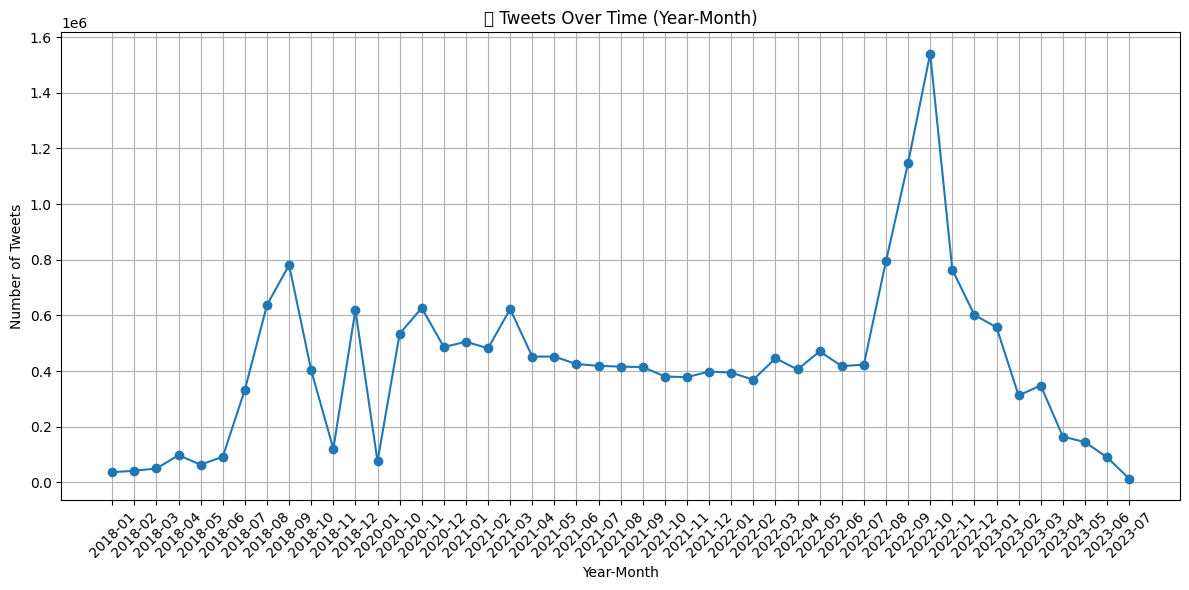

/tmp/ipykernel_1385109/1990738676.py:84: UserWarning: Glyph 127991 (\N{LABEL}) missing from current font.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127991 (\N{LABEL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


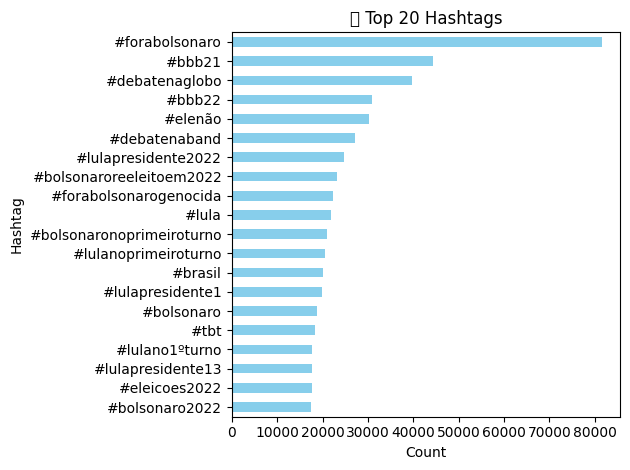

/tmp/ipykernel_1385109/1990738676.py:96: UserWarning: Glyph 128483 (\N{SPEAKING HEAD IN SILHOUETTE}) missing from current font.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128483 (\N{SPEAKING HEAD IN SILHOUETTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


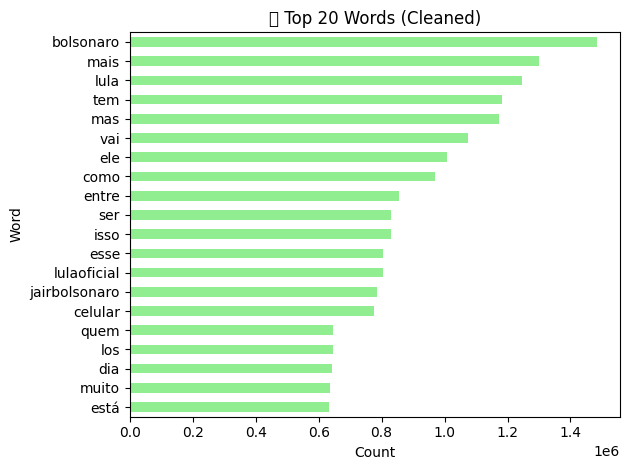

/tmp/ipykernel_1385109/1990738676.py:106: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from current font.
  plt.tight_layout()
/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


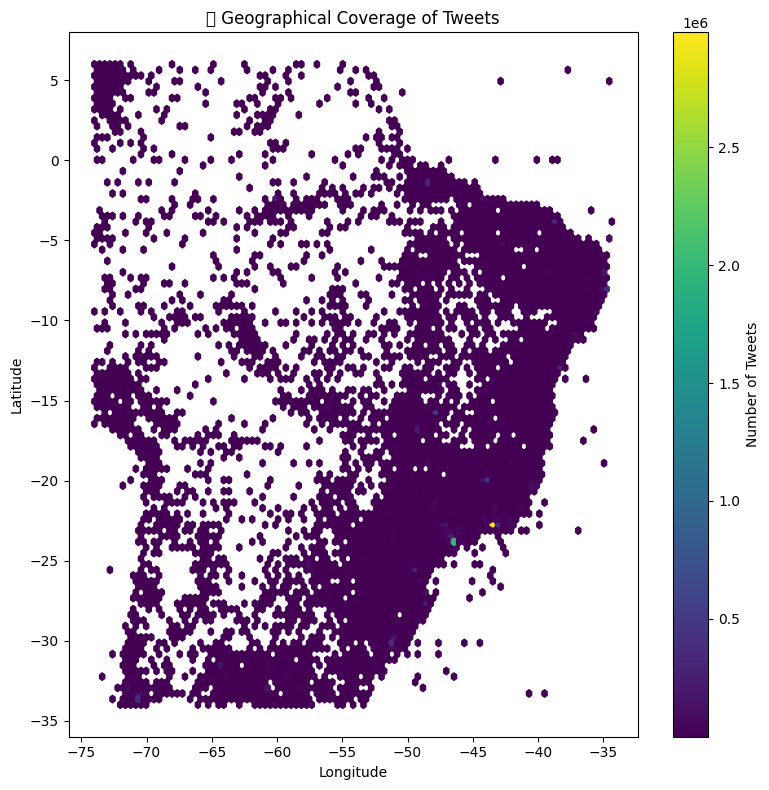


üéâ Block 3 ‚Äî Exploratory Analysis completed.


In [ ]:
# Block 3 ‚Äî Exploratory Analysis (FINAL ‚Äî PATH CORRETO)

import os
import pandas as pd
import glob
import re
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

# CONFIGURATION ‚Äî PATH CORRETO AQUI
FILTERED_DIR_BR = '/n/netscratch/cga/Lab/rpalbuquerque/Elections/filtered_batches_BR/'
BATCH_FILES = sorted(glob.glob(os.path.join(FILTERED_DIR_BR, '*.csv.gz')))
print(f"üìÇ Found {len(BATCH_FILES)} CSV.GZ files to analyze.")

# Initialize counters
date_counter = Counter()
hashtag_counter = Counter()
word_counter = Counter()
latitudes = []
longitudes = []

# Define stopwords (basic Portuguese + some English common)
STOPWORDS = set([
    'de', 'da', 'do', 'das', 'dos', 'e', 'em', 'para', 'por', 'com', 'a', 'o', 'os', 'as',
    'no', 'na', 'nos', 'nas', 'que', 'se', 'um', 'uma', '√©', 'ao', '√†', '√†s', 'foi', 'n√£o',
    'eu', 'vc', 'voc√™', 'pra', 'pro', 'nosso', 'nossa', 'meu', 'minha', 'j√°', 't√°', 'rt',
    'https', 'http', 'co', 'tco'
])

# Regex for hashtags
HASHTAG_REGEX = re.compile(r"#\w+")

# Process batches
for file in tqdm(BATCH_FILES, desc="Processing batches for Exploratory Analysis"):
    df = pd.read_csv(file, sep='\t', low_memory=False)

    # Block 3.1 ‚Äî Temporal Distribution
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['year_month'] = df['date'].dt.to_period('M').astype(str)
    date_counter.update(df['year_month'].dropna().tolist())

    # Block 3.2 ‚Äî Top Hashtags
    hashtags_in_batch = df['text'].str.findall(HASHTAG_REGEX).sum()
    hashtags_in_batch = [h.lower() for h in hashtags_in_batch if h]
    hashtag_counter.update(hashtags_in_batch)

    # Block 3.3 ‚Äî Top Words (cleaned)
    texts = df['text'].dropna().str.lower().tolist()
    for text in texts:
        words = re.findall(r'\b\w+\b', text)
        words_clean = [w for w in words if w not in STOPWORDS and len(w) > 2]
        word_counter.update(words_clean)

    # Block 3.4 ‚Äî Geographical Coverage
    latitudes.extend(df['latitude'].dropna().tolist())
    longitudes.extend(df['longitude'].dropna().tolist())

# --- OUTPUTS ---

## Block 3.1 ‚Äî Temporal Distribution
df_date = pd.DataFrame(date_counter.items(), columns=['Year-Month', 'Tweet Count'])
df_date = df_date.sort_values('Year-Month')

plt.figure(figsize=(12,6))
plt.plot(df_date['Year-Month'], df_date['Tweet Count'], marker='o')
plt.xticks(rotation=45)
plt.title('üìä Tweets Over Time (Year-Month)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.tight_layout()
plt.show()

## Block 3.2 ‚Äî Top Hashtags
top_hashtags = hashtag_counter.most_common(20)
df_hashtags = pd.DataFrame(top_hashtags, columns=['Hashtag', 'Count'])

plt.figure(figsize=(10,6))
df_hashtags.plot(kind='barh', x='Hashtag', y='Count', legend=False, color='skyblue')
plt.gca().invert_yaxis()
plt.title('üè∑Ô∏è Top 20 Hashtags')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

## Block 3.3 ‚Äî Top Words
top_words = word_counter.most_common(20)
df_words = pd.DataFrame(top_words, columns=['Word', 'Count'])

plt.figure(figsize=(10,6))
df_words.plot(kind='barh', x='Word', y='Count', legend=False, color='lightgreen')
plt.gca().invert_yaxis()
plt.title('üó£Ô∏è Top 20 Words (Cleaned)')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

## Block 3.4 ‚Äî Geographical Coverage
plt.figure(figsize=(8,8))
plt.hexbin(longitudes, latitudes, gridsize=100, cmap='viridis', mincnt=1)
plt.colorbar(label='Number of Tweets')
plt.title('üó∫Ô∏è Geographical Coverage of Tweets')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

print("\nüéâ Block 3 ‚Äî Exploratory Analysis completed.")

In [ ]:
##‚úÖ üì¶ Block 4 ‚Äì Refined Filtering for 2018 Elections (Complete and Final Version)

In [ ]:
# üìå Block 4 ‚Äî Refined Filtering with Regex (Final Version with .csv.gz path)

import pandas as pd
import glob
import os
import re
from tqdm import tqdm

# ‚úÖ Corrigir os caminhos!
input_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/filtered_batches_BR/"
output_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/filtered_batches_BR_matched/"
os.makedirs(output_path, exist_ok=True)

# ‚úÖ Palavras-chave completas
candidate_keywords = [
    r'\bbolsonar.*', r'\blula\b', r'\bhaddad\b', r'\bciro\b', r'\bdaciolo\b',
    r'\bmarina\b', r'\balckmin\b', r'\bamoedo\b', r'\bmeirelles\b',
    r'\bsoraya\b', r'\btebet\b', r'\bjanones\b', r'\bboulos\b', r'\bkelmon\b', r'\beymael\b'
]

party_keywords = [
    r'\bpt\b', r'\bpl\b', r'\bpsdb\b', r'\bpdt\b', r'\bpsol\b', r'\bmdb\b',
    r'\bpmdb\b', r'\brepublicanos\b', r'\bnovo\b', r'\bpcb\b', r'\bpstu\b', r'\bup\b'
]

election_keywords = [
    r'\belei√ß.*', r'\burna\b', r'\btse\b', r'\bvoto\b', r'\bvotar\b', r'\bvota√ß√£o\b',
    r'\bjusti√ßa eleitoral\b', r'\bpresidente\b'
]

ideology_keywords = [
    r'\bmito\b', r'\blulalivre\b', r'\bfora bolsonaro\b', r'\bfora lula\b', r'\bvolta lula\b',
    r'\bbozo\b', r'\bpetista\b', r'\bbolsonarista\b',
    r'\bcomunista\b', r'\bfascista\b', r'\bnazista\b', r'\bditadura\b', r'\bdemocracia\b'
]

# ‚úÖ Regex combinada
all_patterns = candidate_keywords + party_keywords + election_keywords + ideology_keywords
combined_pattern = '|'.join(all_patterns)

# üìÇ Arquivos .csv.gz reais
csv_files = sorted(glob.glob(os.path.join(input_path, "*.csv.gz")))
print(f"üìÇ Found {len(csv_files)} CSV.GZ files to filter.")

# üîÅ Loop silencioso com tqdm
for file in tqdm(csv_files, desc="üîç Applying keyword filter"):
    try:
        df = pd.read_csv(file, sep='\t', dtype=str, low_memory=False)

        if 'text' not in df.columns:
            continue

        df['matched_keywords'] = df['text'].str.lower().str.contains(combined_pattern, regex=True, na=False)
        matched_df = df[df['matched_keywords']].copy()

        if not matched_df.empty:
            filename = os.path.basename(file).replace('.csv.gz', '_matched.csv.gz')
            matched_df.to_csv(os.path.join(output_path, filename), sep='\t', index=False, compression='gzip')

    except Exception as e:
        tqdm.write(f"‚ö†Ô∏è Error in file {file}: {e}")

üìÇ Found 31674 CSV.GZ files to filter.


üîç Applying keyword filter: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 31674/31674 [10:59<00:00, 48.01it/s]  


In [ ]:
## üìå Block 5 ‚Äì Filter Only Tweets from 2018 (Until 2018-10-28)

In [ ]:
# üìå Block 5 ‚Äì Filter Only Tweets from 2018 (Until 2018-10-28)

import pandas as pd
import os
import glob
from tqdm import tqdm

# ‚úÖ Paths
matched_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/filtered_batches_BR_matched/"
output_path_2018 = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/filtered_2018_only_until_oct28/"
os.makedirs(output_path_2018, exist_ok=True)

# üìÇ Files to process
matched_files = sorted(glob.glob(os.path.join(matched_path, "*.csv.gz")))
print(f"üìÇ Found {len(matched_files)} matched files to check until 2018-10-28.")

# üîÅ Filtering loop
for file in tqdm(matched_files, desc="üîç Filtering tweets until 2018-10-28"):
    try:
        df = pd.read_csv(file, sep='\t', dtype=str, low_memory=False)
        if 'date' not in df.columns:
            continue

        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df_2018 = df[(df['date'].dt.year == 2018) & (df['date'] <= '2018-10-28')].copy()

        if not df_2018.empty:
            filename = os.path.basename(file).replace(".csv.gz", "_2018pre.csv.gz")
            df_2018.to_csv(os.path.join(output_path_2018, filename), sep='\t', index=False)

    except Exception as e:
        print(f"‚ö†Ô∏è Error in file {file}: {e}")

üìÇ Found 30420 matched files to check until 2018-10-28.


üîç Filtering tweets until 2018-10-28:   7%|‚ñã         | 2071/30420 [00:18<03:53, 121.42it/s]/tmp/ipykernel_1714585/2043939468.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
üîç Filtering tweets until 2018-10-28:  12%|‚ñà‚ñè        | 3636/30420 [00:28<02:58, 149.73it/s]/tmp/ipykernel_1714585/2043939468.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
üîç Filtering tweets until 2018-10-28:  19%|‚ñà‚ñâ        | 5746/30420 [00:43<04:07, 99.72it/s] /tmp/ipykernel_1714585/2043939468.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dat

In [ ]:
##üì¶ Block 5.1 ‚Äî Clean First-Round Vote Data (TSE CSV)

In [ ]:
##‚úÖ Block 6 ‚Äî Assign Municipality to Filtered Tweets (2018 only)

In [ ]:
# üìå Block 5 ‚Äî Spatial Join using pyogrio (GeoJSON-friendly, no Fiona)

import os
import pandas as pd
import pyogrio
import glob
from shapely.geometry import Point
import geopandas as gpd
from tqdm import tqdm

# ‚úÖ Paths
tweets_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/filtered_2018_only_until_oct28/"  # Caminho correto de entrada
geojson_parts = sorted(glob.glob("/n/netscratch/cga/Lab/rpereiraalbuquerque/BR_Census_part_*.geojson"))
output_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/tweets_with_municipality_2018/"
os.makedirs(output_path, exist_ok=True)

# ‚úÖ Load all GeoJSON parts using pyogrio (sem include_geometry)
gdf_list = []
for part in geojson_parts:
    df = pyogrio.read_dataframe(part, read_geometry=True, columns=["CD_MUN", "NM_MUN"])
    gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
    gdf_list.append(gdf)

gdf_mun = pd.concat(gdf_list, ignore_index=True)

# ‚úÖ Process each tweet file
tweet_files = sorted(glob.glob(os.path.join(tweets_path, "*.csv.gz")))
print(f"üìÇ Found {len(tweet_files)} tweet files for spatial join.")

for file in tqdm(tweet_files, desc="Assigning municipalities"):
    try:
        df = pd.read_csv(file, sep="\t", low_memory=False, dtype=str)

        # Skip if lat/lon are missing
        if 'latitude' not in df.columns or 'longitude' not in df.columns:
            continue

        # Drop rows without coordinates
        df = df.dropna(subset=['latitude', 'longitude'])

        # Convert to float and filter out-of-bounds
        df['latitude'] = df['latitude'].astype(float)
        df['longitude'] = df['longitude'].astype(float)
        df = df[(df['latitude'].between(-35, 6)) & (df['longitude'].between(-75, -30))]

        # Build geometry
        df['geometry'] = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
        gdf_tweets = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

        # Spatial join
        joined = gpd.sjoin(gdf_tweets, gdf_mun, how="left", predicate="within")
        matched = joined[~joined['CD_MUN'].isna()].copy()

        # Save only matched rows
        if not matched.empty:
            output_file = os.path.join(output_path, os.path.basename(file))
            matched.drop(columns='geometry').to_csv(output_file, sep='\t', index=False)

    except Exception as e:
        print(f"‚ùå Error processing file {file}: {e}")

üìÇ Found 6240 tweet files for spatial join.


Assigning municipalities: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6240/6240 [20:17<00:00,  5.13it/s]


In [ ]:
##‚úÖ Validation ‚Äì Spatial Join Coverage by Municipality

In [ ]:
# üìä Validation ‚Äì Summary of Tweets per Municipality (CD_MUN)

import os
import pandas as pd
import glob
from tqdm import tqdm

# ‚úÖ Path to processed tweet files
output_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/tweets_with_municipality_2018/"
tweet_files = sorted(glob.glob(os.path.join(output_path, "*.csv.gz")))

# ‚úÖ Aggregate tweets by municipality code
mun_counts = {}

for file in tqdm(tweet_files, desc="Aggregating tweets by CD_MUN"):
    try:
        df = pd.read_csv(file, sep="\t", usecols=["CD_MUN"], dtype=str)
        df = df.dropna(subset=["CD_MUN"])
        counts = df["CD_MUN"].value_counts()
        for code, count in counts.items():
            mun_counts[code] = mun_counts.get(code, 0) + count
    except Exception as e:
        print(f"‚ùå Error in {file}: {e}")

# ‚úÖ Convert to DataFrame
df_mun = pd.DataFrame(list(mun_counts.items()), columns=["CD_MUN", "tweet_count"])
df_mun["CD_UF"] = df_mun["CD_MUN"].str[:2]  # Extract state code (UF)

# ‚úÖ Summary statistics
print("üìå Total tweets matched to municipalities:", df_mun["tweet_count"].sum())
print("üìå Number of municipalities with tweets:", df_mun.shape[0])
print("üìå Top 10 municipalities by tweet volume:")
print(df_mun.sort_values("tweet_count", ascending=False).head(10))

# ‚úÖ Optional: group by state
df_uf = df_mun.groupby("CD_UF")["tweet_count"].sum().reset_index().sort_values("tweet_count", ascending=False)
print("\nüìå Tweet distribution by state (UF):")
print(df_uf.head(10))

Aggregating tweets by CD_MUN: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6142/6142 [00:18<00:00, 327.44it/s]


üìå Total tweets matched to municipalities: 654782
üìå Number of municipalities with tweets: 3888
üìå Top 10 municipalities by tweet volume:
     CD_MUN  tweet_count CD_UF
0   3304557        81543    33
1   3513801        71957    35
2   5300108        26500    53
3   3106200        22121    31
6   4314902        17975    43
4   4106902        16288    41
9   2611606        14703    26
7   2304400        11792    23
18  2927408        11149    29
13  5208707         9345    52

üìå Tweet distribution by state (UF):
   CD_UF  tweet_count
19    35       153739
18    33       131528
16    31        53483
22    43        49760
20    41        32707
12    26        27172
21    42        26595
26    53        26500
15    29        22031
9     23        16639


In [ ]:
##‚úÖ C√≥digo Block 6 ‚Äî Aggregation by Municipality and Day

In [ ]:
# üì¶ Block 6 ‚Äî Aggregate Tweets by Municipality and Date

import os
import pandas as pd
import glob
from tqdm import tqdm

# ‚úÖ Input path (from Block 5)
tweets_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/tweets_with_municipality_2018/"

# ‚úÖ Output path
output_file = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/aggregated_by_municipality_date_2018.csv.gz"

# ‚úÖ List all tweet files with municipality
tweet_files = sorted(glob.glob(os.path.join(tweets_path, "*.csv.gz")))

# ‚úÖ Accumulate daily stats by municipality
aggregated = []

for file in tqdm(tweet_files, desc="Aggregating per municipality-date"):
    try:
        df = pd.read_csv(file, sep="\t", dtype=str, usecols=["CD_MUN", "date", "user_id", "retweets", "latitude", "longitude"])
        df = df.dropna(subset=["CD_MUN", "date"])

        df["CD_UF"] = df["CD_MUN"].str[:2]
        df["retweets"] = pd.to_numeric(df["retweets"], errors="coerce").fillna(0).astype(int)

        # Flag de geolocaliza√ß√£o GPS
        df["has_geo"] = (~df["latitude"].isna()) & (~df["longitude"].isna())

        # Agrupamento por CD_MUN e date
        grouped = df.groupby(["CD_MUN", "CD_UF", "date"]).agg(
            tweet_count=("user_id", "count"),
            unique_users=("user_id", "nunique"),
            retweet_count=("retweets", "sum"),
            geo_coverage=("has_geo", "sum")
        ).reset_index()

        aggregated.append(grouped)

    except Exception as e:
        print(f"‚ùå Error processing {file}: {e}")

# ‚úÖ Concatenate all and export
df_final = pd.concat(aggregated, ignore_index=True)
df_final.to_csv(output_file, index=False, compression="gzip")
print(f"‚úÖ Aggregated data saved to: {output_file}")

Aggregating per municipality-date: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6142/6142 [00:52<00:00, 117.88it/s]


‚úÖ Aggregated data saved to: /n/netscratch/cga/Lab/rpalbuquerque/Elections/aggregated_by_municipality_date_2018.csv.gz


In [ ]:
import pandas as pd

# üì• Load the aggregated file
tweets_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/aggregated_by_municipality_date_2018.csv.gz"
df = pd.read_csv(tweets_path)

# ‚úÖ Padronizar a coluna CD_MUN
df["CD_MUN"] = df["CD_MUN"].astype(str).str.zfill(7)

# üìä Agregar total de tweets por munic√≠pio
df_totals = df.groupby("CD_MUN")["tweet_count"].sum().reset_index()
df_totals = df_totals.rename(columns={"tweet_count": "total_tweets"})

# üßÆ Estat√≠sticas descritivas
print("üìà Summary Statistics:")
print(df_totals["total_tweets"].describe())

# üî¢ Ver quantos munic√≠pios t√™m exatamente 1 tweet
one_tweet = (df_totals["total_tweets"] == 1).sum()
print(f"üìå Munic√≠pios com exatamente 1 tweet: {one_tweet} de {len(df_totals)}")

# üëÄ Exibir amostra
print("\nüîé Amostra dos dados:")
print(df_totals.sort_values("total_tweets").head(10))

üìà Summary Statistics:
count     3888.000000
mean       168.411008
std       1956.025542
min          1.000000
25%          2.000000
50%          8.000000
75%         37.000000
max      81543.000000
Name: total_tweets, dtype: float64
üìå Munic√≠pios com exatamente 1 tweet: 626 de 3888

üîé Amostra dos dados:
       CD_MUN  total_tweets
1943  3169505             1
1603  3127057             1
1602  3126901             1
1600  3126604             1
1597  3125952             1
1596  3125903             1
1593  3125606             1
1589  3124807             1
546   2307635             1
1575  3122801             1


In [ ]:
##‚úÖ Block 7 ‚Äî Merge Tweets with First Round Votes (and Analyze)

In [ ]:
import pandas as pd

# üìÅ Caminhos de entrada
tweets_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/aggregated_by_municipality_date_2018.csv.gz"
votes_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/election_results_2018_first_round_cleaned.csv.gz"
output_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/merged_tweets_votes_2018_round_1.csv.gz"

# üì• Carregar dados
df_tweets = pd.read_csv(tweets_path, dtype={"CD_MUN": str})
df_votes = pd.read_csv(votes_path, dtype={"CD_MUN": str})

# ‚úÖ Padronizar c√≥digo do munic√≠pio (7 d√≠gitos)
df_tweets["CD_MUN"] = df_tweets["CD_MUN"].str.zfill(7)
df_votes["CD_MUN"] = df_votes["CD_MUN"].str.zfill(7)

# üìä Agregar tweets por munic√≠pio (soma de tweet_count de todas as datas)
df_tweets_agg = (
    df_tweets
    .groupby("CD_MUN", as_index=False)
    .agg(total_tweets=("tweet_count", "sum"))
)

# üîÅ Dedupe votos
#    Assumimos que df_votes j√° cont√©m apenas o 1¬∫ turno e uma linha por munic√≠pio
#    Caso contr√°rio, usar drop_duplicates abaixo:
df_votes_dedup = df_votes.drop_duplicates(subset=["CD_MUN"]).copy()

# üîó Merge (+ diagn√≥stico)
df_merged = pd.merge(
    df_tweets_agg,
    df_votes_dedup,
    on="CD_MUN",
    how="inner"
)
print(f"‚úÖ Merge completo: {len(df_merged)} munic√≠pios com dados combinados de tweets e vota√ß√£o.")

# üíæ Salvando sa√≠da
df_merged.to_csv(output_path, index=False, compression="gzip")
print(f"‚úÖ Arquivo salvo em: {output_path}")

# üìå Amostra final
print("\nüìå Visualiza√ß√£o da base final (primeiras linhas):")
print(df_merged[["CD_MUN", "NM_MUNICIPIO", "UF", "total_tweets", "votos_total", "pct_vencedor"]].head())

# üìä Estat√≠sticas r√°pidas
print("\nüìà Estat√≠sticas descritivas de tweets por munic√≠pio:")
print(df_merged["total_tweets"].describe())
print(f"üìå Propor√ß√£o de munic√≠pios sem tweets: {(df_merged['total_tweets']==0).mean():.2%}")

‚úÖ Merge completo: 6 munic√≠pios com dados combinados de tweets e vota√ß√£o.
‚úÖ Arquivo salvo em: /n/netscratch/cga/Lab/rpalbuquerque/Elections/merged_tweets_votes_2018_round_1.csv.gz

üìå Visualiza√ß√£o da base final (primeiras linhas):
    CD_MUN            NM_MUNICIPIO  UF  total_tweets  votos_total  \
0  2109270      S√ÉO VICENTE FERRER  ma             1         9825   
1  2313005  JIJOCA DE JERICOACOARA  ce             4        10790   
2  2313757                   CEDRO  ce             1        14630   
3  3140100                  CATUJI  mg            25         5075   
4  3141009              LUISL√ÇNDIA  mg             5         3997   

   pct_vencedor  
0      0.795623  
1      0.440964  
2      0.441627  
3      0.652414  
4      0.794096  

üìà Estat√≠sticas descritivas de tweets por munic√≠pio:
count     6.000000
mean      6.833333
std       9.086620
min       1.000000
25%       1.750000
50%       4.500000
75%       5.000000
max      25.000000
Name: total_tweets, dtyp

In [ ]:
##üì¶ Block 7 ‚Äî Merge Tweets with First Round Votes (Cleaned + Aggregated)

In [ ]:
print(df_merged.columns.tolist())

['CD_MUN', 'total_tweets', 'UF', 'NM_MUNICIPIO', 'votos_total', 'candidato_vencedor', 'votos_vencedor', 'pct_vencedor']


In [ ]:
print("Tweet CD_MUN sample:", df_tweets_agg["CD_MUN"].unique()[:5])
print("Vote CD_MUN sample:", df_votes["CD_MUN"].unique()[:5])

Tweet CD_MUN sample: ['1100023' '1100031' '1100049' '1100056' '1100064']
Vote CD_MUN sample: ['2210804' '2107161' '2210707' '2623167' '2937222']


In [ ]:
##üì¶ Block 7.1 ‚Äî Diagnose Merge Coverage

In [ ]:
# üìä Check overlap between votes and tweet municipalities
tweets_muns = set(df_tweets_agg["CD_MUN"])
votes_muns = set(df_votes["CD_MUN"])

both = tweets_muns & votes_muns
only_tweets = tweets_muns - votes_muns
only_votes = votes_muns - tweets_muns

print(f"üßÆ Municipalities with tweets: {len(tweets_muns)}")
print(f"üßÆ Municipalities with vote data: {len(votes_muns)}")
print(f"üîó Municipalities in both (eligible for merge): {len(both)}")
print(f"‚ö†Ô∏è Municipalities with vote data but NO tweets: {len(only_votes)}")
print(f"‚ö†Ô∏è Municipalities with tweets but NO vote data: {len(only_tweets)}")

# üìå Show a few unmatched examples
print("\nüîç Example municipalities with vote data but no tweets:")
print(sorted(list(only_votes))[:10])

print("\nüîç Example municipalities with tweets but no vote data:")
print(sorted(list(only_tweets))[:10])

üßÆ Municipalities with tweets: 3888
üßÆ Municipalities with vote data: 5570
üîó Municipalities in both (eligible for merge): 6
‚ö†Ô∏è Municipalities with vote data but NO tweets: 5564
‚ö†Ô∏è Municipalities with tweets but NO vote data: 3882

üîç Example municipalities with vote data but no tweets:
['1100019', '1100035', '1100051', '1100078', '1100094', '1100116', '1100132', '1100159', '1100175', '1100191']

üîç Example municipalities with tweets but no vote data:
['1100023', '1100031', '1100049', '1100056', '1100064', '1100098', '1100106', '1100114', '1100122', '1100130']
